# Beer type preferences

In [142]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Functions

In [2]:
def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process['rating'] = (data_to_process['rating'] - data_to_process['rating'].mean()) / data_to_process['rating'].std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

In [51]:
def styles_rephrase(lst_styles):
    # replace some characters
    old_values = [' ', '-', '/', '(', ')', '&', ',', '____', '___', '__', 'style_']
    for val in old_values:
        lst_styles = lst_styles.str.replace(val,'_')
    
    # remove '_' if in first or last position of style name
    lst_styles = [x.rstrip('_') for x in lst_styles]
    lst_styles = [x.lstrip('_') for x in lst_styles]
    
    return lst_styles

## Loading and selecting data

In [85]:
df_ba = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
df_rb = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')
print(df_ba.columns)
print(df_rb.columns)

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text', 'review', 'user_location',
       'brewery_location', 'nbr_beers_by_brewery', 'zscore'],
      dtype='object')
Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text', 'user_location',
       'brewery_location', 'nbr_beers_by_brewery', 'zscore'],
      dtype='object')


In [116]:
df_ba_style = df_ba[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]
df_rb_style = df_rb[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]
df_styles_reviews = pd.concat([df_ba_style, df_rb_style]).reset_index().drop('index', axis=1).dropna()

# rephrase styles
old_values = [' ', '-', '/', '\(', '\)', '\&', ',']
df_styles_reviews.replace(
    to_replace={'style':old_values},
    value='_',
    regex=True,
    inplace=True,
)
df_styles_reviews.replace(
    to_replace={'style':'____'},
    value='_',
    regex=True,
    inplace=True,
)
df_styles_reviews.replace(
    to_replace={'style':'___'},
    value='_',
    regex=True,
    inplace=True,
)
df_styles_reviews.replace(
    to_replace={'style':'__'},
    value='_',
    regex=True,
    inplace=True,
)
df_styles_reviews['style'] = df_styles_reviews['style'].str.strip('_')

print(df_styles_reviews['style'].unique())
print(len(df_styles_reviews))



['English_Brown_Ale' 'American_Double_Imperial_IPA' 'Weizenbock'
 'Russian_Imperial_Stout' 'American_IPA' 'Quadrupel_Quad' 'Wheatwine'
 'American_Pale_Ale_APA' 'Pumpkin_Ale' 'American_Amber_Red_Ale'
 'Euro_Pale_Lager' 'American_Double_Imperial_Stout' 'Fruit_Vegetable_Beer'
 'Tripel' 'Lambic_Fruit' 'Dortmunder_Export_Lager' 'Herbed_Spiced_Beer'
 'English_Barleywine' 'American_Porter' 'American_Adjunct_Lager'
 'Foreign_Export_Stout' 'Belgian_Pale_Ale' 'Rauchbier' 'American_Stout'
 'Flanders_Red_Ale' 'American_Strong_Ale' 'Altbier' 'Witbier'
 'California_Common_Steam_Beer' 'Schwarzbier' 'German_Pilsener'
 'Saison_Farmhouse_Ale' 'Dubbel' 'American_Malt_Liquor'
 'American_Black_Ale' 'American_Wild_Ale' 'Hefeweizen'
 'American_Brown_Ale' 'Flanders_Oud_Bruin' 'English_Strong_Ale'
 'English_India_Pale_Ale_IPA' 'Irish_Dry_Stout' 'Belgian_IPA'
 'Czech_Pilsener' 'Rye_Beer' 'Winter_Warmer' 'Belgian_Strong_Pale_Ale'
 'Märzen_Oktoberfest' 'Belgian_Strong_Dark_Ale' 'American_Pale_Wheat_Ale'
 'America

In [ ]:
print(len(df_styles_reviews['']))

### load categories

In [196]:
# load csv
df_styles_to_cat = pd.read_csv('../data/preprocessed/styles_to_categories.csv', sep=';')

# add category for each review
df_styles_reviews['category'] = "nothing"
for cat in df_styles_to_cat.columns:
    for style in df_styles_to_cat[cat].dropna():
        df_styles_reviews.loc[df_styles_reviews['style'] == style, 'category'] = cat

print(df_styles_reviews['category'].unique())

American_Double_Imperial_IPA
68813
American_IPA
92716
American_Pale_Ale_APA
35398
Pumpkin_Ale
8880
American_Amber_Red_Ale
18398
Euro_Pale_Lager
5207
Belgian_Pale_Ale
8435
Flanders_Red_Ale
3097
American_Strong_Ale
21078
Saison_Farmhouse_Ale
27279
American_Black_Ale
9158
American_Wild_Ale
23887
English_India_Pale_Ale_IPA
5828
Rye_Beer
4081
Märzen_Oktoberfest
7710
Cream_Ale
4507
English_Pale_Ale
10067
American_Blonde_Ale
6168
Kölsch
7097
English_Bitter
2297
Old_Ale
9529
Scottish_Ale
4194
Irish_Red_Ale
2644
Roggenbier
155
Scottish_Gruit_Ancient_Herbed_Ale
776
Kellerbier_Zwickelbier
1156
English_Pale_Mild_Ale
253
American_Pale_Ale
27286
India_Pale_Ale_IPA
53862
Traditional_Ale
3463
Golden_Ale_Blond_Ale
17612
Imperial_IPA
26566
Premium_Bitter_ESB
11146
Scotch_Ale
4681
Mild_Ale
2987
Bitter
14646
Session_IPA
5780
Amber_Ale
12921
Irish_Ale
2763
Quadrupel_Quad
8383
Tripel
10634
Dubbel
5909
Belgian_IPA
7049
Belgian_Strong_Pale_Ale
10285
Belgian_Strong_Dark_Ale
11670
Belgian_Dark_Ale
1668
Belgian_

## Sorting by countries

In [301]:
user_loc_count = df_styles_reviews.groupby(['user_location'])['user_location'].count().sort_values(ascending=False)

# select 10 samples with the most reviews:
"""print(len(user_loc_count))
user_loc_count = user_loc_count[:10]"""
user_loc_count = user_loc_count[user_loc_count > 100]
user_loc_count = user_loc_count[:10]
print(user_loc_count)

user_location
United States, California       94391
United States, Pennsylvania     85412
Canada                          77944
United States, Illinois         70746
United States, New York         62099
Denmark                         57723
United States, Texas            51296
England                         48077
United States, Massachusetts    45477
United States, Ohio             44612
Name: user_location, dtype: int64


## Finding favourite category

In [302]:
df_cat_location_dumm = pd.get_dummies(df_styles_reviews, columns=['category'])
best_cat_per_user_location = {}

# remove special characters in columns names
#df_cat_location_dumm.columns = styles_rephrase(df_styles_location_dumm.columns)
df_cat_location_dumm.columns = df_cat_location_dumm.columns.str.replace('category_', '')

# transform boolean values to int values for linear regression
for col in df_cat_location_dumm.drop(['beer_id', 'beer_name', 'brewery_name', 'brewery_location','user_location', 'brewery_id', 'rating','style'], axis=1).columns:
    df_cat_location_dumm[col] = df_cat_location_dumm[col] * 1

# perform linear regression on each location
columns= list(df_cat_location_dumm.drop(['beer_id', 'beer_name', 'user_location', 'brewery_name', 'brewery_location', 'brewery_id', 'rating', 'style'], axis=1).columns)
for idx, loc in enumerate(list(user_loc_count.keys())):
    print(loc)
    df_reviews = df_cat_location_dumm[df_styles_reviews['user_location'] == loc]
    res = get_LR(df_reviews, columns)
    print(res.params.sort_values(ascending=False)[0:3])
    best_cat_per_user_location[loc] = res.params.sort_values(ascending=False)[0:3]

United States, California
STOUTS       0.591949
SOURS        0.447969
PALE_ALES    0.380837
dtype: float64
United States, Pennsylvania
STOUTS      0.540875
SOURS       0.453722
BELGIANS    0.374156
dtype: float64
Canada
STOUTS      0.454295
BELGIANS    0.379139
SOURS       0.377731
dtype: float64
United States, Illinois
STOUTS       0.589677
SOURS        0.389470
PALE_ALES    0.339895
dtype: float64
United States, New York
STOUTS      0.504115
SOURS       0.446456
BELGIANS    0.366715
dtype: float64
Denmark
SOURS      0.965848
STOUTS     0.864513
PORTERS    0.685149
dtype: float64
United States, Texas
STOUTS     0.563816
PORTERS    0.357421
SOURS      0.336688
dtype: float64
England
SOURS       0.456419
STOUTS      0.452801
BELGIANS    0.367406
dtype: float64
United States, Massachusetts
STOUTS       0.528037
SOURS        0.464210
PALE_ALES    0.369456
dtype: float64
United States, Ohio
STOUTS      0.619405
SOURS       0.444840
BELGIANS    0.406285
dtype: float64


In [303]:
print(best_cat_per_user_location)

{'United States, California': STOUTS       0.591949
SOURS        0.447969
PALE_ALES    0.380837
dtype: float64, 'United States, Pennsylvania': STOUTS      0.540875
SOURS       0.453722
BELGIANS    0.374156
dtype: float64, 'Canada': STOUTS      0.454295
BELGIANS    0.379139
SOURS       0.377731
dtype: float64, 'United States, Illinois': STOUTS       0.589677
SOURS        0.389470
PALE_ALES    0.339895
dtype: float64, 'United States, New York': STOUTS      0.504115
SOURS       0.446456
BELGIANS    0.366715
dtype: float64, 'Denmark': SOURS      0.965848
STOUTS     0.864513
PORTERS    0.685149
dtype: float64, 'United States, Texas': STOUTS     0.563816
PORTERS    0.357421
SOURS      0.336688
dtype: float64, 'England': SOURS       0.456419
STOUTS      0.452801
BELGIANS    0.367406
dtype: float64, 'United States, Massachusetts': STOUTS       0.528037
SOURS        0.464210
PALE_ALES    0.369456
dtype: float64, 'United States, Ohio': STOUTS      0.619405
SOURS       0.444840
BELGIANS    0.4062

## Finding local breweries

In [304]:
frac_reviews_per_brewery = {}

# loop on every location
for idx, loc in tqdm(enumerate(list(user_loc_count.keys())), total=len(list(user_loc_count.keys()))):

    # total number of reviews per brewery
    num_reviews_per_brewery = df_styles_reviews[df_styles_reviews['brewery_location'] == loc] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)

    # number of local reviews per brewery
    num_reviews_per_brewery_loc = df_styles_reviews[(df_styles_reviews['brewery_location'] == loc) & (df_styles_reviews['user_location'] == loc)] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)
    """print(len(num_reviews_per_brewery))
    print(len(num_reviews_per_brewery_loc))"""
    num_reviews_per_brewery.keys = num_reviews_per_brewery_loc.keys
    num_reviews_per_brewery = num_reviews_per_brewery.loc[num_reviews_per_brewery_loc.keys()]
    """print(len(num_reviews_per_brewery))
    print(num_reviews_per_brewery_loc.divide(num_reviews_per_brewery).sort_values(ascending=False))
    print(num_reviews_per_brewery)
    print(num_reviews_per_brewery_loc)"""
    # fraction of local rewviews per brewery (90% and up)
    frac_reviews_per_brewery[loc] = num_reviews_per_brewery_loc.divide(num_reviews_per_brewery).sort_values(ascending=False)
    #frac_reviews_per_brewery[loc] = frac_reviews_per_brewery[loc][frac_reviews_per_brewery[loc].values > .9]
    

100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


In [305]:
print(len(frac_reviews_per_brewery))
lst_empty_loc = []
for loc in frac_reviews_per_brewery:
    if len(frac_reviews_per_brewery[loc]) == 0:
        lst_empty_loc.append(loc)
print(lst_empty_loc)
for loc in lst_empty_loc:
    frac_reviews_per_brewery.pop(loc)
print(len(frac_reviews_per_brewery))
lst_locations = list(frac_reviews_per_brewery.keys())
print(lst_locations)

10
[]
10
['United States, California', 'United States, Pennsylvania', 'Canada', 'United States, Illinois', 'United States, New York', 'Denmark', 'United States, Texas', 'England', 'United States, Massachusetts', 'United States, Ohio']


## Looking for each country if local breweries is answering to local preferences

### Get the global average representation of each style

In [351]:
retrain_glob_frac = False
if retrain_glob_frac:
    global_frac_per_cat = {}
    for cat in df_styles_reviews.category.unique():
        print(cat)
        global_frac_per_cat[cat] = 0
        for brewery in list(df_styles_reviews.brewery_name.unique()):
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))
            if val != []:
                global_frac_per_cat[cat] += val[0]
        global_frac_per_cat[cat] /= len(df_styles_reviews.brewery_name.unique())
    print(global_frac_per_cat)

In [336]:
global_frac_per_cat = {'BROWNS': 0.03483138963510579, 'PALE_ALES': 0.41155088541346874, 'WHEATS': 0.07872893800006803, 'STOUTS': 0.10731777909188722, 'BELGIANS': 0.05461235901529182, 'OTHER': 0.09424647167577703, 'SOURS': 0.013466836131315111, 'LAGERS': 0.15911566743367156, 'PORTERS': 0.046129673603413864}
print(global_frac_per_cat)

{'BROWNS': 0.03483138963510579, 'PALE_ALES': 0.41155088541346874, 'WHEATS': 0.07872893800006803, 'STOUTS': 0.10731777909188722, 'BELGIANS': 0.05461235901529182, 'OTHER': 0.09424647167577703, 'SOURS': 0.013466836131315111, 'LAGERS': 0.15911566743367156, 'PORTERS': 0.046129673603413864}


### Compare for each location

In [341]:
# loop on every location
frac_per_loc_per_cat = {}
for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
    breweries = frac_reviews_per_brewery[loc].keys()

    #styles = styles_rephrase(best_type_per_user_location[loc].keys())
    cats = best_cat_per_user_location[loc].keys()
    frac_per_loc_per_cat[loc] = {}
    for cat in cats:

        frac_per_loc_per_cat[loc][cat] = 0
        for brewery in breweries:
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

            if val != []:
                frac_per_loc_per_cat[loc][cat] += val[0]
            
        if len(breweries) > 0:
            frac_per_loc_per_cat[loc][cat] /= len(breweries)
        else:
            print("No breweries for : " + loc)

        
    

100%|██████████| 10/10 [15:57<00:00, 95.80s/it]


In [342]:
print(frac_per_loc_per_cat)

{'United States, California': {'STOUTS': 0.11618097525133723, 'SOURS': 0.02253265007883408, 'PALE_ALES': 0.5468200631792175}, 'United States, Pennsylvania': {'STOUTS': 0.1287614669076564, 'SOURS': 0.01677724653797061, 'BELGIANS': 0.05091062374734319}, 'Canada': {'STOUTS': 0.0929970233006377, 'BELGIANS': 0.04044126694037812, 'SOURS': 0.01447080354647508}, 'United States, Illinois': {'STOUTS': 0.14035942779111613, 'SOURS': 0.022719910681909553, 'PALE_ALES': 0.4511635015981748}, 'United States, New York': {'STOUTS': 0.11676368609766861, 'SOURS': 0.019726766478097162, 'BELGIANS': 0.037501064490499315}, 'Denmark': {'SOURS': 0.021848536846973132, 'STOUTS': 0.1166015627762815, 'PORTERS': 0.04753588772380788}, 'United States, Texas': {'STOUTS': 0.14658966492258538, 'PORTERS': 0.06890530217711797, 'SOURS': 0.01928097664646492}, 'England': {'SOURS': 0.006316863612099365, 'STOUTS': 0.10510268636115704, 'BELGIANS': 0.007529807167422576}, 'United States, Massachusetts': {'STOUTS': 0.107806765986457

In [343]:
diff_frac_per_loc_per_cat = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat[loc] = {}
    print(loc)
    for cat in frac_per_loc_per_cat[loc]:
        print(cat)
        diff_frac_per_loc_per_cat[loc][cat] = frac_per_loc_per_cat[loc][cat] - global_frac_per_cat[cat]

United States, California
STOUTS
SOURS
PALE_ALES
United States, Pennsylvania
STOUTS
SOURS
BELGIANS
Canada
STOUTS
BELGIANS
SOURS
United States, Illinois
STOUTS
SOURS
PALE_ALES
United States, New York
STOUTS
SOURS
BELGIANS
Denmark
SOURS
STOUTS
PORTERS
United States, Texas
STOUTS
PORTERS
SOURS
England
SOURS
STOUTS
BELGIANS
United States, Massachusetts
STOUTS
SOURS
PALE_ALES
United States, Ohio
STOUTS
SOURS
BELGIANS


In [350]:
for loc in lst_locations:
    print(loc)
    mean_deviation = 0
    for cat in diff_frac_per_loc_per_cat[loc]:
        mean_deviation += diff_frac_per_loc_per_cat[loc][cat]
        print(diff_frac_per_loc_per_cat[loc][cat])
    print(mean_deviation/3)
    #print(diff_frac_per_loc_per_cat[loc])
#print(diff_frac_per_loc_per_cat)

United States, California
0.008863196159450012
0.009065813947518968
0.13526917776574876
0.051066062624239246
United States, Pennsylvania
0.02144368781576919
0.0033104104066555007
-0.003701735267948633
0.007017454318158686
Canada
-0.014320755791249529
-0.014171092074913703
0.0010039674151599686
-0.009162626817001087
United States, Illinois
0.033041648699228904
0.009253074550594442
0.03961261618470607
0.027302446478176475
United States, New York
0.009445907005781393
0.006259930346782051
-0.017111294524792507
-0.0004684857240763544
Denmark
0.008381700715658021
0.009283783684394281
0.001406214120394017
0.0063572328401487735
United States, Texas
0.039271885830698156
0.02277562857370411
0.005814140515149811
0.022620551639850692
England
-0.007149972519215746
-0.0022150927307301865
-0.04708255184786925
-0.01881587236593839
United States, Massachusetts
0.0004889868945698733
-0.0015174500222589482
0.17007521872089093
0.05634891853106729
United States, Ohio
0.03599823561870019
0.00415482635335080

## Show results

In [ ]:
# Loop through each country and perform linear regression
for country in merged_data['location'].unique():
    country_data = merged_data[merged_data['location'] == country]
    try:
        res=get_LR(country_data, columns_of_interest)
        main_predictor = res.params.idxmax()  # Get the main predictor with the highest coefficient
        results = pd.concat([results, pd.DataFrame({'country': [country], 'main_predictor': [main_predictor]})], ignore_index=True)
    except:
        pass

In [404]:
lst_shapefile = ['Northern Mariana Islands', 'Kuril Islands', 'France', 'Serbia', 'Uruguay', 'Guam', 'Panama', 'Netherlands Antilles', 'Algeria', 'Togo', "Ma'tan al-Sarra", 'Switzerland', 'Jersey', 'Austria', 'Portugal', 'Luxembourg', 'Kazakhstan', 'Aruba', 'Holy See', 'Equatorial Guinea', 'Jamaica', 'Estonia', 'Niger', 'Belize', 'Morocco', 'Malta', 'Finland', 'Turkey', 'Lithuania', 'Russian Federation', 'Zimbabwe', 'Singapore', 'Oman', 'Republic of Korea', 'Montserrat', 'Liberia', 'Rwanda', 'Nicaragua', 'Mozambique', 'Mayotte', 'Cameroon', 'Hong Kong', 'Yemen', 'Western Sahara', 'Tokelau', 'Grenada', 'Cayman Islands', 'Dominican Republic', 'Argentina', 'Congo', 'Bahamas', 'Chile', 'Guinea', 'British Indian Ocean Territory', 'Saint Kitts and Nevis', 'Solomon Islands', 'Pitcairn Island', 'Saint Lucia', 'Turkmenistan', 'French Southern and Antarctic Territories', 'Slovenia', 'El Salvador', 'Cook Islands', 'Uganda', 'Uzbekistan', 'Ireland', 'Eritrea', 'Kuwait', 'Brunei Darussalam', 'Cape Verde', 'Italy', 'Iran (Islamic Republic of)', 'United Arab Emirates', 'British Virgin Islands', 'San Marino', 'Zambia', 'Latvia', 'Marshall Islands', 'Syrian Arab Republic', 'Sri Lanka', 'Glorioso Islands', 'Paracel Islands', 'Guernsey', 'Palau', 'Canada', 'Ethiopia', 'Greenland', 'Comoros', 'Abyei', 'Guatemala', 'Kyrgyzstan', 'Suriname', 'Poland', 'Ilemi Triangle', 'Spratly Islands', 'Bermuda', 'Arunachal Pradesh', 'South Sudan', 'Bulgaria', 'U.K. of Great Britain and Northern Ireland', 'Bahrain', 'Niue', 'Somalia', 'Barbados', 'Puerto Rico', 'Seychelles', 'Senegal', 'Greece', 'West Bank', 'Guantanamo', 'Costa Rica', 'Indonesia', 'Liechtenstein', 'Kiribati', 'Fiji', 'Malawi', 'Nigeria', 'Norfolk Island', 'Aksai Chin', 'Monaco', 'Gambia', 'Timor-Leste', 'Honduras', 'Botswana', 'Burkina Faso', 'Ukraine', 'Swaziland', 'New Caledonia', 'Falkland Islands (Malvinas)', 'Pakistan', 'South Africa', "Democratic People's Republic of Korea", 'Maldives', 'Lebanon', 'Christmas Island', 'United States Virgin Islands', 'Faroe Islands', 'Lesotho', 'Tajikistan', 'Burundi', 'Philippines', 'Madagascar', 'Azerbaijan', 'Mauritania', 'Egypt', 'Germany', "Côte d'Ivoire", 'India', 'Venezuela', 'Bhutan', 'Sierra Leone', 'Tonga', 'Dominica', 'Bosnia & Herzegovina', 'Jordan', 'Qatar', 'Tuvalu', 'Saint Vincent and the Grenadines', 'Gaza Strip', 'Jarvis Island', 'Montenegro', 'Svalbard and Jan Mayen Islands', 'Vietnam', 'Croatia', 'Isle of Man', 'Iceland', 'Namibia', 'Moldova, Republic of', 'Nauru', 'Thailand', 'Nepal', 'American Samoa', 'Andorra', 'Australia', 'Bouvet Island', 'The former Yugoslav Republic of Macedonia', 'Peru', 'Benin', 'Paraguay', 'Midway Is.', 'Reunion', 'Saudi Arabia', 'Taiwan', 'Guadeloupe', 'Central African Republic', 'French Polynesia', 'Azores Islands', 'Brazil', 'Haiti', 'Hungary', 'Djibouti', 'Vanuatu', 'Cambodia', 'Georgia', 'South Georgia & the South Sandwich Islands', 'Mongolia', 'Spain', 'Cyprus', 'Macao', 'Jammu-Kashmir', 'Heard Island and McDonald Islands', 'French Guiana', 'Democratic Republic of the Congo', 'Guinea-Bissau', 'Papua New Guinea', 'Turks and Caicos Islands', 'Bolivia', 'Cuba', 'China', 'Iraq', 'Martinique', 'Malaysia', 'Sweden', 'Ghana', 'Angola', 'Antigua & Barbuda', 'Norway', 'Bangladesh', 'Denmark', 'Belgium', 'Samoa', 'Anguilla', 'Israel', 'Libyan Arab Jamahiriya', 'Mexico', 'Romania', 'Belarus', 'Ecuador', 'Sudan', 'United Republic of Tanzania', 'Micronesia (Federated States of)', "Hala'ib Triangle", 'Myanmar', 'Mauritius', 'Cocos (Keeling) Islands', 'Afghanistan', 'Sao Tome and Principe', 'Colombia', 'Czech Republic', 'Japan', "Lao People's Democratic Republic", 'Tunisia', 'Guyana', 'Gabon', 'Netherlands', 'Chad', 'Trinidad and Tobago', 'Slovakia', 'Mali', 'Armenia', 'Albania', 'Gibraltar', 'New Zealand', 'Madeira Islands', 'Kenya', 'North Dakota', 'Alaska', 'Washington', 'New Mexico', 'Massachusetts', 'Utah', 'Oregon', 'Mississippi', 'Kentucky', 'Idaho', 'Maine', 'Iowa', 'Oklahoma', 'Arkansas', 'Wisconsin', 'Florida', 'Connecticut', 'Maryland', 'Wyoming', 'Hawaii', 'Arizona', 'Louisiana', 'Indiana', 'New Hampshire', 'Ohio', 'Virginia', 'District of Columbia', 'New Jersey', 'South Dakota', 'North Carolina', 'South Carolina', 'Nebraska', 'Colorado', 'Texas', 'West Virginia', 'Missouri', 'New York', 'California', 'Tennessee', 'Minnesota', 'Vermont', 'Kansas', 'Nevada', 'Rhode Island', 'Michigan', 'Delaware', 'Illinois', 'Commonwealth of the Northern Mariana Islands', 'Pennsylvania', 'Alabama', 'Montana']
print(len(lst_shapefile))

306


Index(['iso3', 'status', 'color_code', 'name', 'continent', 'region',
       'iso_3166_1_', 'french_shor', 'geometry'],
      dtype='object')
0        North Dakota
1              Alaska
2          Washington
3          New Mexico
4       Massachusetts
            ...      
163        California
164    North Carolina
165              Utah
166           Montana
167      Pennsylvania
Name: ste_name, Length: 168, dtype: object
256
255
['Northern Mariana Islands', 'Kuril Islands', 'France', 'Serbia', 'Uruguay', 'Guam', 'Panama', 'Netherlands Antilles', 'Algeria', 'Togo', "Ma'tan al-Sarra", 'Switzerland', 'Jersey', 'Austria', 'Portugal', 'Luxembourg', 'Kazakhstan', 'Aruba', 'Holy See', 'Equatorial Guinea', 'Jamaica', 'Estonia', 'Niger', 'Belize', 'Morocco', 'Malta', 'Finland', 'Turkey', 'Lithuania', 'Russian Federation', 'Zimbabwe', 'Singapore', 'Oman', 'Republic of Korea', 'Montserrat', 'Liberia', 'Rwanda', 'Nicaragua', 'Mozambique', 'Mayotte', 'Cameroon', 'Hong Kong', 'Yemen', 'Western Sah

C:\Users\swann\AppData\Local\Temp\ipykernel_24276\2122347849.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)


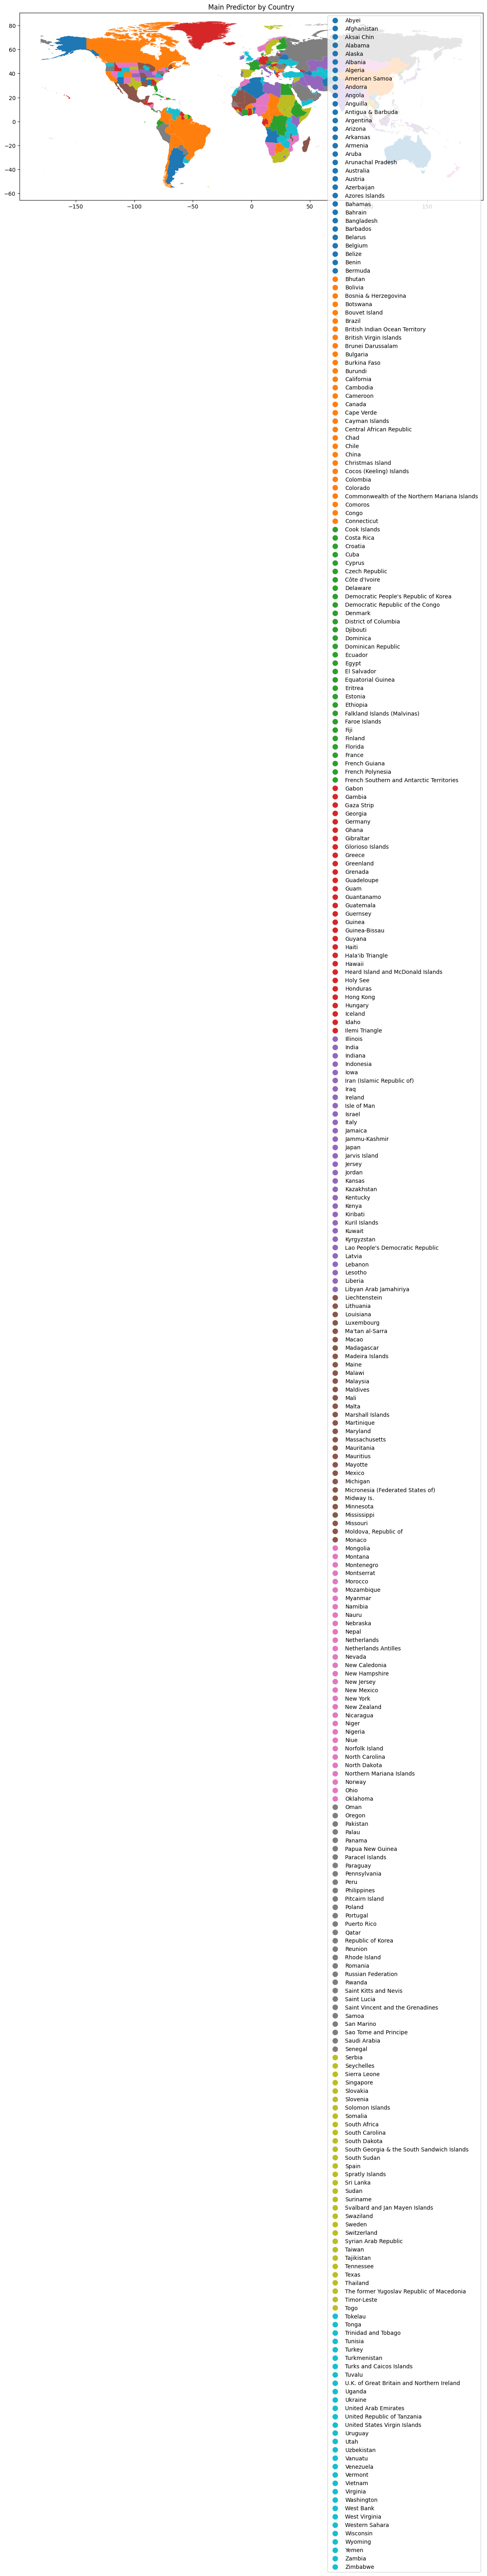

In [402]:


# Load a world shapefile for mapping (you may need to download a suitable shapefile)
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file('../data/shapefiles/world-administrative-boundaries.zip')
states = gpd.read_file('../data/shapefiles/georef-united-states-of-america-state-millesime.zip')
print(world.columns)
states.ste_name = states.ste_name.str.replace("['", "")
states.ste_name = states.ste_name.str.replace("']", "")
print(states.ste_name)
print(len(world))
world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
print(len(world_clean))
states_clean = states[['ste_name','geometry']]
states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)
print(list(world_clean.name))
print(states_clean.columns)
shapefile = pd.concat([world_clean, states_clean], axis=0)
print(list(shapefile.name.unique()))
"""print(states.ste_name.unique())
print(len(states))"""

# Merge the world shapefile with the results DataFrame
#world = world.merge(results, left_on='name', right_on='country', how='left')

# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#world.boundary.plot(ax=ax, linewidth=1)
shapefile.plot(column='name', ax=ax, legend=True)
plt.title('Main Predictor by Country')
plt.show()

In [ ]:
lst_names = ['Northern Mariana Islands', 'Kuril Islands', 'France', 'Serbia', 'Uruguay', 'Guam', 'Panama', 'Netherlands Antilles', 'Algeria', 'Togo', "Ma'tan al-Sarra", 'Switzerland', 'Jersey', 'Austria', 'Portugal', 'Luxembourg', 'Kazakhstan', 'Aruba', 'Holy See', 'Equatorial Guinea', 'Jamaica', 'Estonia', 'Niger', 'Belize', 'Morocco', 'Malta', 'Finland', 'Turkey', 'Lithuania', 'Russian Federation', 'Zimbabwe', 'Singapore', 'Oman', 'Republic of Korea', 'Montserrat', 'Liberia', 'Rwanda', 'Nicaragua', 'Mozambique', 'Mayotte', 'Cameroon', 'Hong Kong', 'Yemen', 'Western Sahara', 'Tokelau', 'Grenada', 'Cayman Islands', 'Dominican Republic', 'Argentina', 'Congo', 'Bahamas', 'Chile', 'Guinea', 'British Indian Ocean Territory', 'Saint Kitts and Nevis', 'Solomon Islands', 'Pitcairn Island', 'Saint Lucia', 'Turkmenistan', 'French Southern and Antarctic Territories', 'Slovenia', 'El Salvador', 'Cook Islands', 'Uganda', 'Uzbekistan', 'Ireland', 'Eritrea', 'Kuwait', 'Brunei Darussalam', 'Cape Verde', 'Italy', 'Iran (Islamic Republic of)', 'United Arab Emirates', 'British Virgin Islands', 'San Marino', 'Zambia', 'Latvia', 'Marshall Islands', 'Syrian Arab Republic', 'Sri Lanka', 'Glorioso Islands', 'Paracel Islands', 'Guernsey', 'Palau', 'Canada', 'Ethiopia', 'Greenland', 'Comoros', 'Abyei', 'Guatemala', 'Kyrgyzstan', 'Suriname', 'Poland', 'Ilemi Triangle', 'Spratly Islands', 'Bermuda', 'Arunachal Pradesh', 'South Sudan', 'Bulgaria', 'U.K. of Great Britain and Northern Ireland', 'Bahrain', 'Niue', 'Somalia', 'Barbados', 'Puerto Rico', 'Seychelles', 'Senegal', 'Greece', 'West Bank', 'Guantanamo', 'Costa Rica', 'Indonesia', 'Liechtenstein', 'Kiribati', 'Fiji', 'Malawi', 'Nigeria', 'Norfolk Island', 'Aksai Chin', 'Monaco', 'Gambia', 'Timor-Leste', 'Honduras', 'Botswana', 'Burkina Faso', 'Ukraine', 'Swaziland', 'New Caledonia', 'Falkland Islands (Malvinas)', 'Pakistan', 'South Africa', "Democratic People's Republic of Korea", 'Maldives', 'Lebanon', 'Christmas Island', 'United States Virgin Islands', 'Faroe Islands', 'Lesotho', 'Tajikistan', 'Burundi', 'Philippines', 'Madagascar', 'Azerbaijan', 'Mauritania', 'Egypt', 'Germany', "Côte d'Ivoire", 'India', 'Venezuela', 'Bhutan', 'Sierra Leone', 'Tonga', 'Dominica', 'Bosnia & Herzegovina', 'Jordan', 'Qatar', 'Tuvalu', 'Saint Vincent and the Grenadines', 'Gaza Strip', 'Jarvis Island', 'Montenegro', 'Svalbard and Jan Mayen Islands', 'Vietnam', 'Croatia', 'Isle of Man', 'Iceland', 'Namibia', 'Moldova, Republic of', 'Nauru', 'Thailand', 'Nepal', 'American Samoa', 'Andorra', 'Australia', 'Bouvet Island', 'The former Yugoslav Republic of Macedonia', 'Peru', 'Benin', 'Paraguay', 'Midway Is.', 'Reunion', 'Saudi Arabia', 'Taiwan', 'Guadeloupe', 'Central African Republic', 'French Polynesia', 'Azores Islands', 'Brazil', 'Haiti', 'Hungary', 'Djibouti', 'Vanuatu', 'Cambodia', 'Georgia', 'South Georgia & the South Sandwich Islands', 'Mongolia', 'Spain', 'Cyprus', 'Macao', 'Jammu-Kashmir', 'Heard Island and McDonald Islands', 'French Guiana', 'Democratic Republic of the Congo', 'Guinea-Bissau', 'Papua New Guinea', 'Turks and Caicos Islands', 'Bolivia', 'Cuba', 'China', 'Iraq', 'Martinique', 'Malaysia', 'Sweden', 'Ghana', 'Angola', 'Antigua & Barbuda', 'Norway', 'Bangladesh', 'Denmark', 'Belgium', 'Samoa', 'Anguilla', 'Israel', 'Libyan Arab Jamahiriya', 'Mexico', 'Romania', 'Belarus', 'Ecuador', 'Sudan', 'United Republic of Tanzania', 'Micronesia (Federated States of)', "Hala'ib Triangle", 'Myanmar', 'Mauritius', 'Cocos (Keeling) Islands', 'Afghanistan', 'Sao Tome and Principe', 'Colombia', 'Czech Republic', 'Japan', "Lao People's Democratic Republic", 'Tunisia', 'Guyana', 'Gabon', 'Netherlands', 'Chad', 'Trinidad and Tobago', 'Slovakia', 'Mali', 'Armenia', 'Albania', 'Gibraltar', 'New Zealand', 'Madeira Islands', 'Kenya', "['North Dakota']", "['Alaska']", "['Washington']", "['New Mexico']", "['Massachusetts']", "['Utah']", "['Oregon']", "['Mississippi']", "['Kentucky']", "['Idaho']", "['Maine']", "['Iowa']", "['Oklahoma']", "['Arkansas']", "['Wisconsin']", "['Florida']", "['Connecticut']", "['Maryland']", "['Wyoming']", "['Hawaii']", "['Arizona']", "['Louisiana']", "['Indiana']", "['New Hampshire']", "['Ohio']", "['Virginia']", "['District of Columbia']", "['New Jersey']", "['Georgia']", "['South Dakota']", "['American Samoa']", "['United States Virgin Islands']", "['North Carolina']", "['South Carolina']", "['Nebraska']", "['Colorado']", "['Texas']", "['West Virginia']", "['Puerto Rico']", "['Missouri']", "['New York']", "['California']", "['Tennessee']", "['Minnesota']", "['Vermont']", "['Kansas']", "['Guam']", "['Nevada']", "['Rhode Island']", "['Michigan']", "['Delaware']", "['Illinois']", "['Commonwealth of the Northern Mariana Islands']", "['Pennsylvania']", "['Alabama']", "['Montana']"]

# Check for each country, what is the main country provider

# code here

# OLD STUFF

The first part of the analysis is to find the main predictor for each country

In [352]:
from utils import *
import numpy as np
import statsmodels.api as sm

# REDUCED = None
REDUCED = 2e5

# Preprocessed ratings 
preprocessed_ratings_ba = load_data("pre_ba", REDUCED)
preprocessed_ratings_ba['same_country'] = (preprocessed_ratings_ba['user_location'] == preprocessed_ratings_ba['brewery_location']).astype(int)


FileNotFoundError: [Errno 2] No such file or directory: '../data/preprocessed/BeerAdvocate/preprocessed_ratings_ba.csv.zip'

In [15]:
preprocessed_ratings_ba = pd.get_dummies(preprocessed_ratings_ba,columns=['style', 'user_location', 'brewery_location'], dtype='int')

In [16]:
columns_of_interest = ['abv','same_country']
columns_of_interest += [col for col in preprocessed_ratings_ba.columns if ('style_' in col or 'location_' in col)] 

In [17]:
X = preprocessed_ratings_ba[columns_of_interest]  # Predictors
y = preprocessed_ratings_ba['zscore']             # Target variable
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 zscore   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     144.0
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:47:40   Log-Likelihood:            -2.5299e+05
No. Observations:              200000   AIC:                         5.065e+05
Df Residuals:                  199738   BIC:                         5.092e+05
Df Model:                         261                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process = (data_to_process - data_to_process.mean()) / data_to_process.std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

# Merge the datasets using the "user_id" column
merged_data = pd.merge(ratings_ba, users_ba[['user_id', 'location']], on='user_id', how='inner')

# Create an empty DataFrame to store regression results
results = pd.DataFrame(columns=['country', 'main_predictor'])

# Define the columns of interest (predictors)
columns_of_interest = ["appearance", "aroma", "palate", "taste", "overall"]

# Loop through each country and perform linear regression
for country in merged_data['location'].unique():
    country_data = merged_data[merged_data['location'] == country]
    try:
        res=get_LR(country_data, columns_of_interest)
        main_predictor = res.params.idxmax()  # Get the main predictor with the highest coefficient
        results = pd.concat([results, pd.DataFrame({'country': [country], 'main_predictor': [main_predictor]})], ignore_index=True)
    except:
        pass



# Load a world shapefile for mapping (you may need to download a suitable shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world shapefile with the results DataFrame
world = world.merge(results, left_on='name', right_on='country', how='left')

# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='main_predictor', cmap='coolwarm', ax=ax, legend=True)
plt.title('Main Predictor by Country')
plt.show()
